In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [16]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
Yen_Futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
Yen_Futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [17]:
# Trim the dataset to begin on January 1st, 1990
Yen_Futures = Yen_Futures.loc["1990-01-01":, :]
Yen_Futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [19]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
Yen_Futures['Return'] = Yen_Futures['Settle'].pct_change().replace(np.inf, np.nan).replace(-np.inf, np.nan) * 100
Yen_Futures = Yen_Futures.dropna()
Yen_Futures['Lagged_Return'] = Yen_Futures.Return.shift()
Yen_Futures.tail()

<ipython-input-19-3f923e68132c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yen_Futures['Lagged_Return'] = Yen_Futures.Return.shift()


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Lagged Returns 

In [20]:
# Create a lagged return using the shift function
Yen_Futures['Lagged_Return'] = Yen_Futures['Return'].shift()
Yen_Futures.dropna(inplace=True)
Yen_Futures.tail()

<ipython-input-20-bc986cfac357>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yen_Futures['Lagged_Return'] = Yen_Futures['Return'].shift()
<ipython-input-20-bc986cfac357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Yen_Futures.dropna(inplace=True)


,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


### Train Test Split

In [25]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
Train = Yen_Futures[:'2017']
Test = Yen_Futures['2018':]

In [26]:
Train.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


In [27]:
# Create four dataframes:
X_Train = Train.drop(columns=["Return"])
X_Test = Test.drop(columns=["Return"])
y_Train = Train["Return"].to_frame()
y_Test = Test["Return"].to_frame()

In [28]:
X_Train

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Lagged_Return
Date,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.020502
...,...,...,...,...,...,...,...,...,...
2017-12-22,8871.0,8882.5,8864.5,8880.5,10.5,8881.0,71339.0,230870.0,0.084621
2017-12-26,8879.0,8898.5,8873.5,8884.5,10.5,8891.5,33864.0,229084.0,0.118370
2017-12-27,8887.0,8895.0,8869.0,8870.5,13.5,8878.0,86378.0,228295.0,0.118230


# Linear Regression Model

In [29]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
Model = LinearRegression()
Model
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
Model.fit(X_Train, y_Train)


LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [30]:
# Make a prediction of "y" values using just the test dataset
Predictions = pd.DataFrame(Model.predict(X_Test), index=X_Test.index)
Predictions

,0
Date,
2018-01-02,0.318917
2018-01-03,-0.279760
2018-01-04,-0.203871
2018-01-05,-0.326671
2018-01-08,0.020844
...,...
2019-10-09,-0.489524
2019-10-10,-0.456408
2019-10-11,-0.642809


In [31]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_Test
Results["Predicted Return"] = Predictions

Results.head()

,Return,Predicted Return
Date,,
2018-01-02,0.297285,0.318917
2018-01-03,-0.240479,-0.279760
2018-01-04,-0.213028,-0.203871
2018-01-05,-0.353933,-0.326671
2018-01-08,0.062017,0.020844


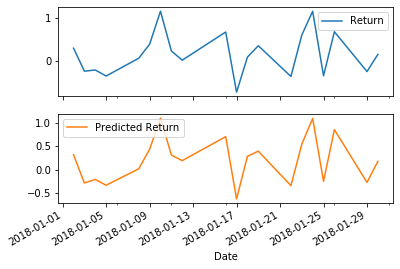

In [32]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True);

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [33]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
MSE = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
RMSE = np.sqrt(MSE)
print(f"Out-of-sample Root Mean Squared Error (RMSE): {RMSE}")

Out-of-sample Root Mean Squared Error (RMSE): 0.16921667882257302


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [34]:
# Construct a dataframe using just the "y" training data:
Data_Frame = pd.DataFrame(y_Train, index=y_Train.index)

# Add a column of "in-sample" predictions to that dataframe:  
Data_Frame['In-Sample Predictions'] = Model.predict(X_Train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
Data_Frame_MSE = mean_squared_error(
    Data_Frame["Return"],
    Data_Frame["In-Sample Predictions"]
)
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
Data_Frame_RMSE = np.sqrt(Data_Frame_MSE)
print(f"In-sample Mean Squared Error (MSE): {Data_Frame_MSE}")
print(f"In-sample Root Mean Squared Error (RMSE): {Data_Frame_RMSE}")

In-sample Mean Squared Error (MSE): 0.026266619219663282
In-sample Root Mean Squared Error (RMSE): 0.16206979737034066


# Conclusions

YOUR CONCLUSIONS HERE!

I think this prediction is accurate because the smaller the Mean Squared Error, the closer the fit is to the data. In this case our MSE is 0.026266619219663282 and that very small.